In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip install cython pyyaml==5.1

Looking in indexes: https://download.pytorch.org/whl/cu121
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-k6_2i_2c
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-k6_2i_2c
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp310-cp310-linux_x86_64.whl size=101098 sha256=9f36f2d58d14fc3820005da37fb8dca72adf22eaf82c08ba1a71c62ee2ce6c7b
  Stored in directory: /tmp/pip-ephem-wheel-cache-sd3it_x8/wheels/39/61/b4/480fbddb4d3d6bc34083e7397bc6f5d1381f79acc68e9f3511
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.8
    Uninstalling pycocotools-2.0.8:
      Successfully uninstalled pycocotools-2.0.8
ERROR: pip's dependency resolver does not currently take into account all the package

In [2]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-q4nyc33y
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-q4nyc33y
  Resolved https://github.com/facebookresearch/detectron2.git to commit 9131ce0e5bc0c89904541bc0355d933ccd6acbfb
  Preparing metadata (setup.py) ... done
  Using cached pycocotools-2.0.8-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.1 kB)
Using cached pycocotools-2.0.8-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (427 kB)
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0


In [3]:
import torch
import detectron2
from detectron2.utils.logger import setup_logger
import os

setup_logger()

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [4]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("deepfashion_train", {}, "/kaggle/input/df2-train-img/ann_train.json", "/kaggle/input/df2-train-img/train_image/image")

In [5]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("deepfashion_train",)
cfg.DATASETS.TEST = ()

# Load pre-trained weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml") 

# Resize images: shorter edge = 800px, longer edge ≤ 1333px
cfg.INPUT.MIN_SIZE_TRAIN = (800,)
cfg.INPUT.MAX_SIZE_TRAIN = 1333
cfg.INPUT.MIN_SIZE_TEST = 800
cfg.INPUT.MAX_SIZE_TEST = 1333

# Set batch and GPU settings
cfg.SOLVER.IMS_PER_BATCH = 4  # Total batch size (2 images per GPU * 8 GPUs)
cfg.SOLVER.BASE_LR = 0.02  # Start learning rate
cfg.SOLVER.MOMENTUM = 0.9
cfg.SOLVER.WEIGHT_DECAY = 1e-5

# Learning rate schedule (for 1x schedule)
cfg.SOLVER.STEPS = (8 * cfg.SOLVER.MAX_ITER // 12, 11 * cfg.SOLVER.MAX_ITER // 12)  # Decrease LR at 8 and 11 epochs
cfg.SOLVER.GAMMA = 0.1
cfg.SOLVER.MAX_ITER = int(12 * 1000)  # Adjust based on dataset size and 1x schedule

# Set ROI head for specific class count (number of classes in your dataset)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 13

# Output directory
cfg.OUTPUT_DIR = "/kaggle/working"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [6]:
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)

[11/08 16:09:56 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_2d9806.pkl: 431MB [00:02, 209MB/s]                             


In [7]:
trainer.train()

[11/08 16:12:54 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[11/08 16:13:56 d2.utils.events]:  eta: 9:42:21  iter: 19  total_loss: 3.502  loss_cls: 2.111  loss_box_reg: 0.6642  loss_mask: 0.6903  loss_rpn_cls: 0.02279  loss_rpn_loc: 0.02422    time: 2.9969  last_time: 2.9159  data_time: 0.0446  last_data_time: 0.0095   lr: 0.00039962  max_mem: 10955M
[11/08 16:14:58 d2.utils.events]:  eta: 9:40:18  iter: 39  total_loss: 2.026  loss_cls: 0.6561  loss_box_reg: 0.6659  loss_mask: 0.6552  loss_rpn_cls: 0.01513  loss_rpn_loc: 0.01964    time: 2.9616  last_time: 2.8996  data_time: 0.0129  last_data_time: 0.0158   lr: 0.00079922  max_mem: 10955M
[11/08 16:15:57 d2.utils.events]:  eta: 9:39:33  iter: 59  total_loss: 1.923  loss_cls: 0.6346  loss_box_reg: 0.7549  loss_mask: 0.5773  loss_rpn_cls: 0.01168  loss_rpn_loc: 0.01285    time: 2.9541  last_time: 2.8295  data_time: 0.0142  last_data_time: 0.0125   lr: 0.0011988  max_mem: 10955M
[11/08 16:16:55 d2.utils.events]:  eta: 9:38:15  iter: 79  total_loss: 1.827  loss_cls: 0.6318  loss_box_reg: 0.7479  lo

KeyboardInterrupt: 

In [20]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0004999.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.55 # set the testing threshold for this model
cfg.DATASETS.TEST = ("deepfashion_train", )
predictor = DefaultPredictor(cfg)

[11/08 20:34:35 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /kaggle/working/model_0004999.pth ...


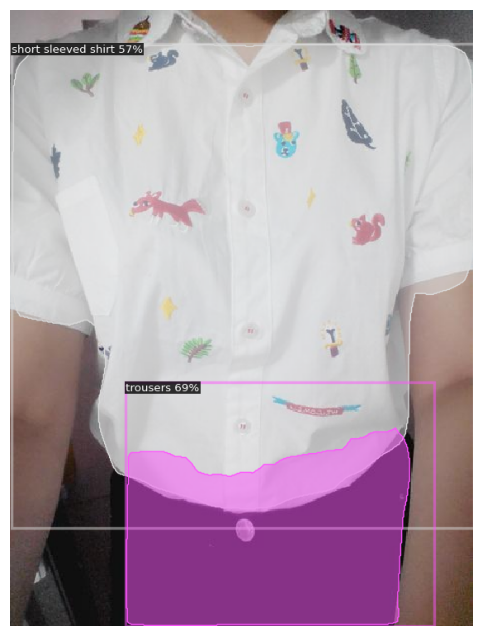

In [17]:
import cv2
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# Чтение изображения в формате RGB
im = cv2.cvtColor(cv2.imread("/kaggle/input/df2-train-img/train_image/image/011528.jpg"), cv2.COLOR_BGR2RGB)

# Получение предсказаний от модели
outputs = predictor(im)

# Визуализация предсказаний
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Использование matplotlib для отображения изображения
plt.figure(figsize=(12, 8))
plt.imshow(v.get_image()[:, :, ::-1])  # Изображение уже в формате RGB, поэтому конвертация не требуется
plt.axis("off")  # Скрыть оси
plt.show()

In [21]:
from IPython.display import FileLink

FileLink("model_0004999.pth")

/kaggle/working/model_0004999.pth